# Mini-Project : COVID-19 Cough Audio Classification

1. Explore the dataset through code
    * How many samples does the dataset contain?
    * How many classes? How many samples per class? Show a histogram of the number of instances per class
    * Play a random sample from each class
    * Describe if/how you think the data distribution will affect training of a classifier.
    * Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice

In [4]:
def preprocess_data(data_meta_path, data_dir_path, output_dir):
    # Read data file then remove every column other than the specified columns
    # Removes empty samples and filters through cough probability
    data = pd.read_csv(data_meta_path, sep=",")
    data = data[["uuid", "cough_detected", "SNR", "age", "gender", "status"]].loc[data["cough_detected"] >= 0.8].dropna().reset_index(drop=True).sort_values(by="cough_detected")
    data = data[(data["gender"] != "other")]

    # Count the occurrences of each age value
    age_counts = data["age"].value_counts()

    # Filter out ages with fewer than 100 samples
    ages_to_keep = age_counts.index[age_counts >= 100]

    # Filter the DataFrame based on the selected ages
    data = data[data["age"].isin(ages_to_keep)]

    # Check if the following MP3 with uuid exists
    mp3_data = []
    non_exist = []
    for file in data["uuid"]:
        if os.path.exists(os.path.join(data_dir_path, f"{file}.mp3")):
            mp3_data.append(os.path.join(data_dir_path, f"{file}.mp3"))
        else:
            non_exist.append(file)

    # Remove entries with missing MP3 files from the original data
    data = data[~data["uuid"].isin(non_exist)]

    # Replace the uuids with the path to uuid
    data["uuid"] = mp3_data

    # Save the data as csv
    data.to_csv(os.path.join(output_dir, "filtered_audio_data.csv"), index=False)

    print("Finished processing!")

def visualize_dataset(data, title, feature, normalize=False, labels=True):
    print(title)
    print(data_len := data[feature].value_counts(normalize=normalize).sort_index())
    print("Total samples", data_len.sum())
    
    plt.figure(figsize=(6, 4))
    plt.title(f"{title}")
    bars = plt.bar(data[feature].value_counts().index, data[feature].value_counts())
    plt.xticks(ha="right", fontsize=10)
    if feature == "status":
        plt.xlabel("Class", fontsize=12)
    else:
        title = title.split()
        plt.xlabel(title[0], fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    # Adding labels to each bar
    if labels:
        for bar, count in zip(bars, data[feature].value_counts()):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01 * max(data[feature].value_counts()), count,
                    ha='center', fontsize=10)
    plt.show()    
    
def remove_silence(audio_object, min_silence_ms=100, threshold_dBFS=-40, keep_silence=100, seek_step=1):
    from pydub.silence import split_on_silence
    # Check for loudness (DEBUGGING)
    # loudness_dBFS = audio_object.dBFS
    # print("Loudness (dBFS):", loudness_dBFS)

    # Attempt to split and remove silence from the audio signal
    audio_segments = split_on_silence(audio_object, min_silence_ms, threshold_dBFS, keep_silence, seek_step)

    # Check if audio_segments is empty if yes return the original audio object as numpy array
    if not audio_segments:

        # Get the array of samples from the audio segment
        org_audio = np.array(audio_object.get_array_of_samples(), dtype=np.float32)

        # Normalize the samples if needed
        org_audio /= np.max(np.abs(org_audio))

        return org_audio

    # Add the different audio segments together
    audio_processed = sum(audio_segments)

    # Return the samples from the processed audio, save as numpy array, and normalize it
    audio_processed = np.array(audio_processed.get_array_of_samples(), dtype=np.float32)
    audio_processed /= np.max(np.abs(audio_processed))

    return audio_processed

def plot_waveform(y1,y2,y3, sr):
    # Plot waveform
    time1 = np.arange(0, len(y1)) / sr
    time2 = np.arange(0, len(y2)) / sr
    time3 = np.arange(0, len(y3)) / sr

    plt.figure(figsize=(10, 8))
    plt.subplot(3,1,1)
    plt.plot(time1, y1)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform - Healthy')
    plt.grid()

    plt.subplot(3,1,2)
    plt.plot(time2, y2)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform - Symptomatic')
    plt.grid()

    plt.subplot(3,1,3)
    plt.plot(time3, y3)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform - COVID-19')
    plt.grid()

    plt.tight_layout()
    plt.show()

def preprocess_dataset(data, test_size):
    from sklearn.model_selection import train_test_split
    # Extract audio samples and labels
    X = data.drop(columns=["status"])
    y = data["status"]

    # Perform a stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Combine audio samples and target labels for training and validation sets
    train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

    return train_data, test_data

def undersample(data, minority_class_label, n):
    # Identify minority class
    minority_class = minority_class_label

    # Calculate desired class distribution (e.g., balanced distribution)
    desired_class_count = n  # Target number of samples for each class

    # Select subset from minority class
    undersampled_data_minority = data[data["status"] == minority_class].sample(n=desired_class_count)

    # Combine with samples from majority classes
    undersampled_data_majority = data[~(data["status"] == minority_class)]

    # Combine undersampled minority class with majority classes
    undersampled_data = pd.concat([undersampled_data_majority, undersampled_data_minority])

    # Shuffle the undersampled dataset
    undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)

    return undersampled_data


"""
data_path = r"misc_data/metadata_compiled.csv"
data_dir_path = r"../Dataset/MP3/"
output_dir = r"misc_data/"
preprocess_data(data_path, data_dir_path, output_dir)
"""

'\ndata_path = r"misc_data/metadata_compiled.csv"\ndata_dir_path = r"../Dataset/MP3/"\noutput_dir = r"misc_data/"\npreprocess_data(data_path, data_dir_path, output_dir)\n'

# 1. Understanding the data

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reading the meta data file
data_path = r"misc_data/metadata_compiled.csv"
data = pd.read_csv(data_path)

print(data)
#visualize_dataset(data, "Class distribution", "status")

                                       uuid                          datetime  \
0      00014dcc-0f06-4c27-8c7b-737b18a2cf4c  2020-11-25T18:58:50.488301+00:00   
1      00039425-7f3a-42aa-ac13-834aaa2b6b92  2020-04-13T21:30:59.801831+00:00   
2      0007c6f1-5441-40e6-9aaf-a761d8f2da3b  2020-10-18T15:38:38.205870+00:00   
3      0009eb28-d8be-4dc1-92bb-907e53bc5c7a  2020-04-12T04:02:18.159383+00:00   
4      0012c608-33d0-4ef7-bde3-75a0b1a0024e  2020-04-15T01:03:59.029326+00:00   
...                                     ...                               ...   
27545  fff30afc-db62-4408-a585-07ca9a254fcc  2020-11-05T08:26:04.219206+00:00   
27546  fff3ff61-2387-4139-938b-539db01e6be5  2020-06-28T21:28:21.530881+00:00   
27547  fff474bf-39a4-4a61-8348-6b992fb5e439  2020-04-10T05:10:36.787070+00:00   
27548  fffaa9f8-4db0-46c5-90fb-93b7b014b55d  2020-04-13T18:58:26.954663+00:00   
27549  fffce9f0-a5e8-4bee-b13b-c671aac4a61c  2020-04-14T13:02:33.307684+00:00   

       cough_detected      

# 2. Choosing interesting features and visualizing the data

##### Choosing interesting features to keep and trying to visualize the data distribution

Class distribution
status
COVID-19        1155
healthy        12479
symptomatic     2590
Name: count, dtype: int64
Total samples 16224


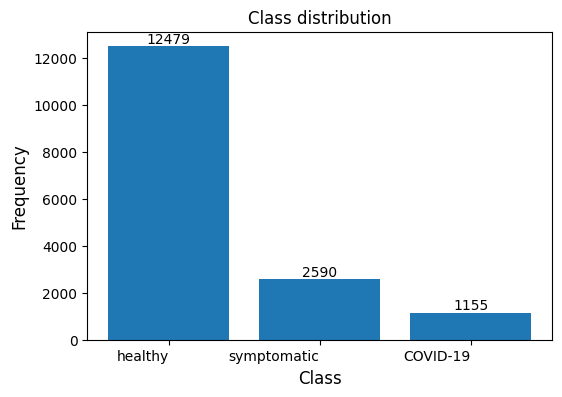

Age distribution
age
1.0      28
2.0      11
3.0      12
4.0      21
5.0      14
         ..
96.0      2
97.0      1
98.0      1
99.0      1
102.0     2
Name: count, Length: 95, dtype: int64
Total samples 15218


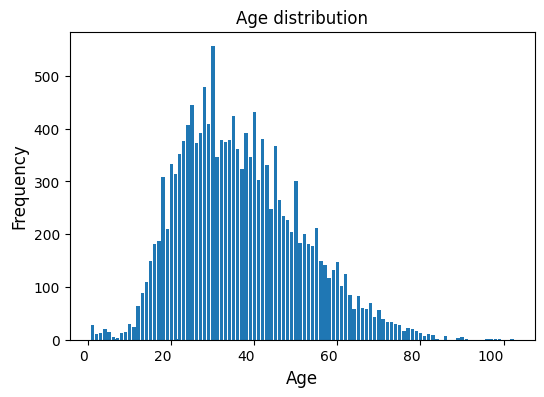

Gender distribution
gender
female     5700
male      10418
other       106
Name: count, dtype: int64
Total samples 16224


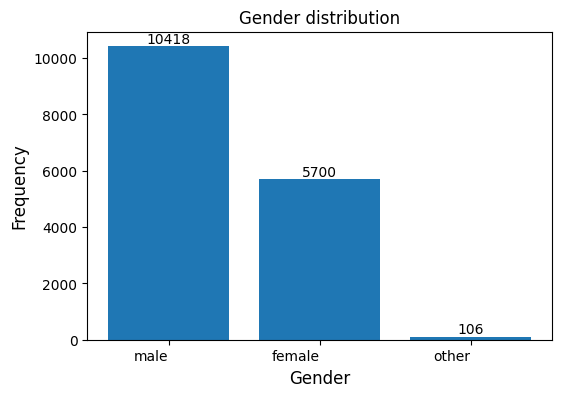

In [6]:
# Selecting features to keep
data = data[["uuid", "cough_detected", "SNR", "age", "gender", "status"]].sort_values(by="cough_detected")
data.to_csv("selection_data.csv", index=False)

visualize_dataset(data, "Class distribution", "status")
visualize_dataset(data, "Age distribution", "age", labels=False)
visualize_dataset(data, "Gender distribution", "gender")

##### Filtering out some of the data

Class distribution
status
COVID-19        497
healthy        6866
symptomatic    1633
Name: count, dtype: int64
Total samples 8996


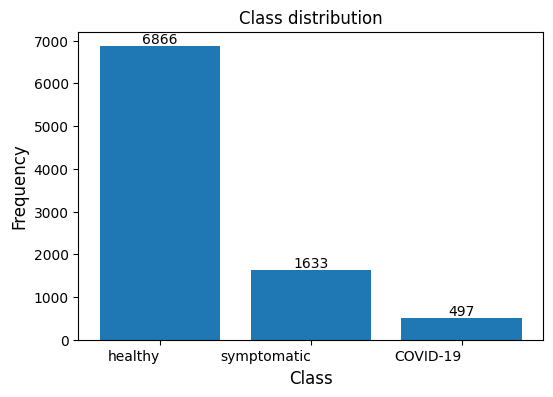

Age distribution
age
16.0    126
17.0    117
18.0    192
19.0    157
20.0    234
21.0    230
22.0    241
23.0    238
24.0    289
25.0    298
26.0    251
27.0    263
28.0    340
29.0    285
30.0    377
31.0    235
32.0    283
33.0    286
34.0    258
35.0    303
36.0    236
37.0    230
38.0    278
39.0    240
40.0    315
41.0    212
42.0    275
43.0    239
44.0    180
45.0    245
46.0    185
47.0    160
48.0    158
49.0    145
50.0    202
51.0    103
52.0    127
53.0    112
54.0    111
55.0    135
56.0    105
Name: count, dtype: int64
Total samples 8996


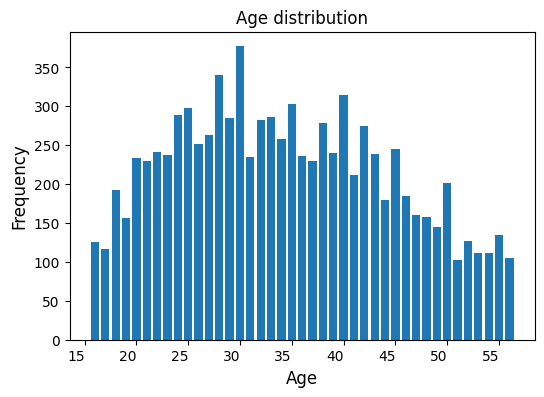

Gender distribution
gender
female    2720
male      6276
Name: count, dtype: int64
Total samples 8996


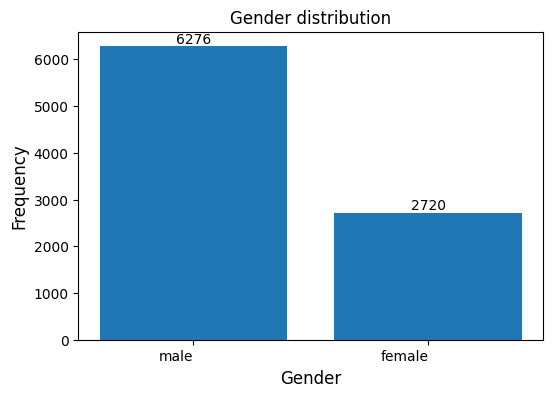

In [7]:
# Filtering features based on cough probability
data = data.loc[data["cough_detected"] >= 0.8].dropna().reset_index(drop=True).sort_values(by="cough_detected")

# Filter out "other" gender
data = data[(data["gender"] != "other")]

# Filter out ages with fewer than 100 samples
age_counts = data["age"].value_counts()
ages_to_keep = age_counts.index[age_counts >= 100]
data = data[data["age"].isin(ages_to_keep)]

data.to_csv("filtered_data.csv")

visualize_dataset(data, "Class distribution", "status")
visualize_dataset(data, "Age distribution", "age", labels=False)
visualize_dataset(data, "Gender distribution", "gender")

# 3. Visualizing the audio samples

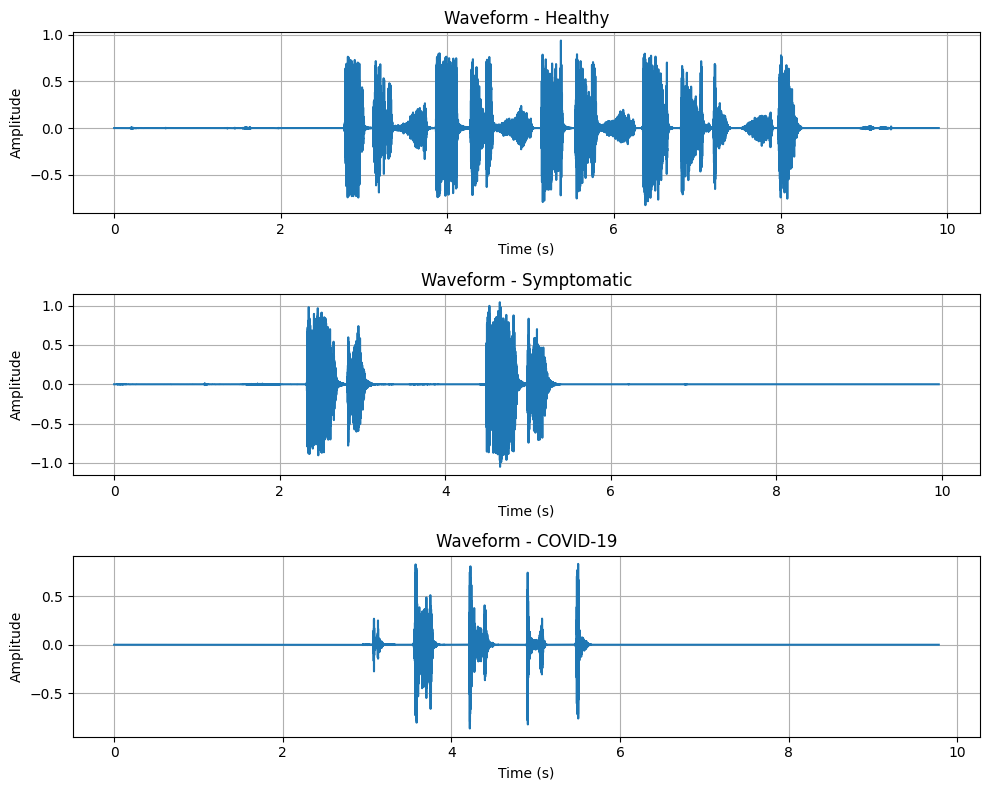

In [8]:
import librosa
import librosa.display

# Load audio file
audio_file1 = r"../Dataset/MP3/004c24d8-e8cd-4755-86f6-5a1d8c7920c7.mp3" # Healthy
audio_file2 = r"../Dataset/MP3/008c1c9e-aeef-40c5-846c-24f1b964f884.mp3" # Symptomatic
audio_file3 = r"../Dataset/MP3/015576c8-2b03-4dcb-b251-78a984fe86fe.mp3" # COVID-19
y1, sr = librosa.load(audio_file1)
y2, _ = librosa.load(audio_file2)
y3, _ = librosa.load(audio_file3)

# Plot waveform
plot_waveform(y1,y2,y3,sr)

##### Filtering out silence

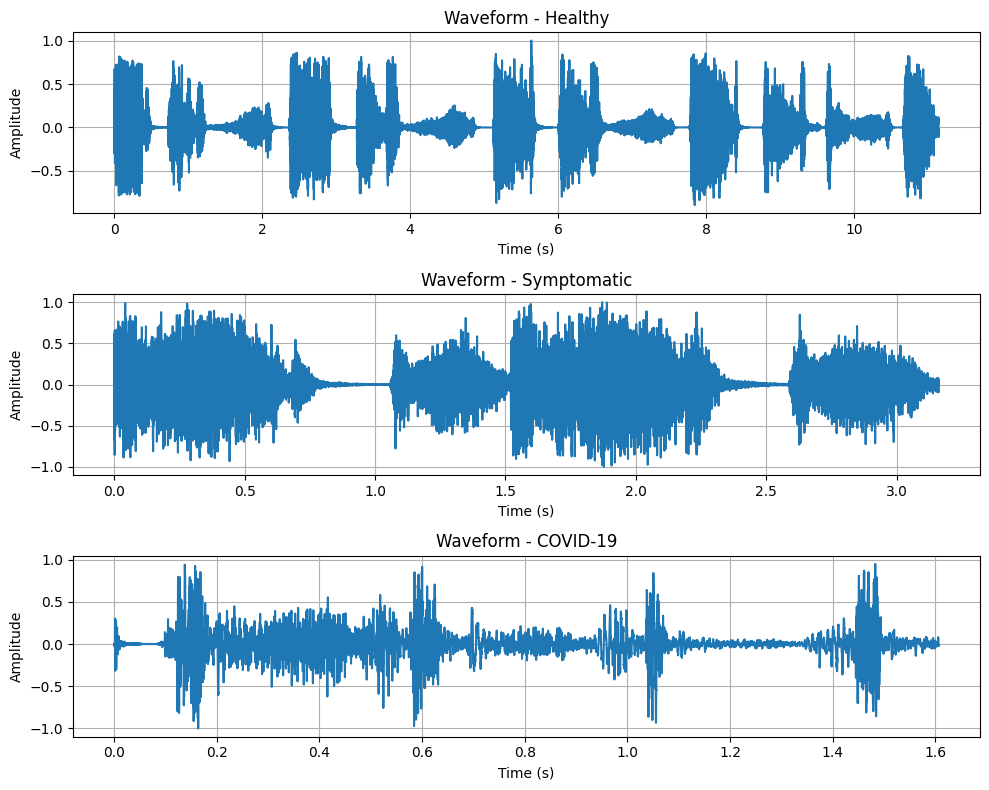

In [9]:
from pydub import AudioSegment

# Silence arguments
min_silence = 200
threshold_dBFS = -40
keep_silence = 0

audio_object1 = AudioSegment.from_file(audio_file1)
audio_object2 = AudioSegment.from_file(audio_file2)
audio_object3 = AudioSegment.from_file(audio_file3)
y1 = remove_silence(audio_object1, min_silence, threshold_dBFS, keep_silence)
y2 = remove_silence(audio_object2, min_silence, threshold_dBFS, keep_silence)
y3 = remove_silence(audio_object3, min_silence, threshold_dBFS, keep_silence)

plot_waveform(y1,y2,y3,sr)

# 4. Handling dataset imbalance

Original distribution
status
COVID-19        497
healthy        6866
symptomatic    1633
Name: count, dtype: int64
Total samples 8996


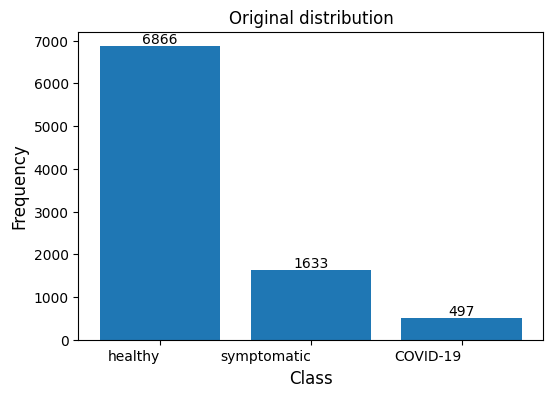

Undersampled distribution
status
COVID-19       497
healthy        500
symptomatic    500
Name: count, dtype: int64
Total samples 1497


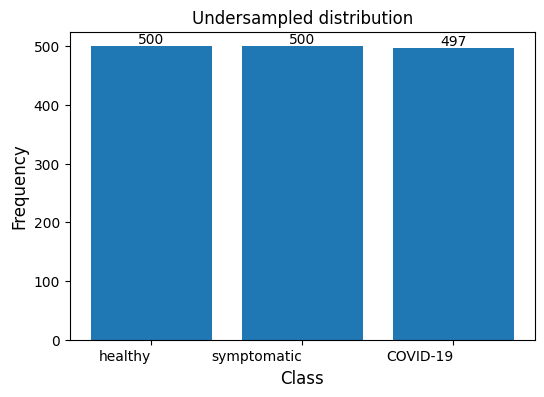

Training distribution
status
COVID-19       347
healthy        350
symptomatic    350
Name: count, dtype: int64
Total samples 1047


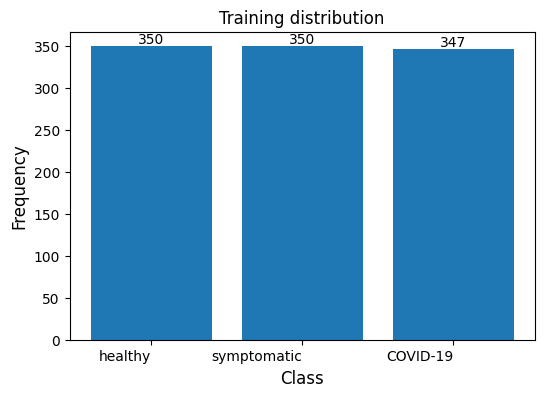

Validation distribution
status
COVID-19       75
healthy        75
symptomatic    75
Name: count, dtype: int64
Total samples 225


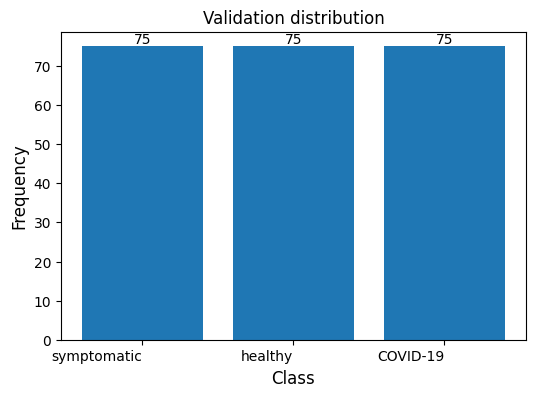

Testing distribution
status
COVID-19       75
healthy        75
symptomatic    75
Name: count, dtype: int64
Total samples 225


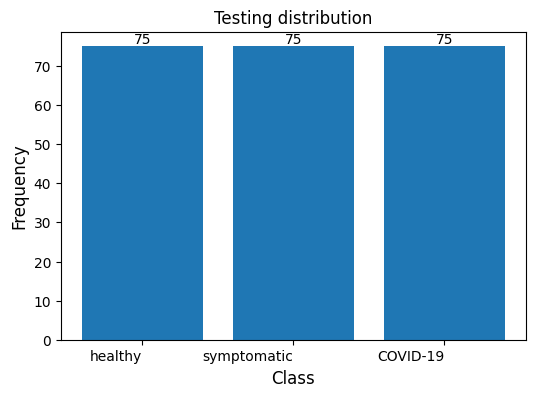

In [11]:
# Prepare and create undersampled version
data = pd.read_csv("filtered_data.csv")
n_classes = 500
undersampled_data = undersample(data, "healthy", n_classes)
undersampled_data = undersample(undersampled_data, "symptomatic", n_classes)
train_data, val_data = preprocess_dataset(undersampled_data, 0.3) 
val_data, test_data = preprocess_dataset(val_data, 0.5)

# Visualizing dataset
visualize_dataset(data, "Original distribution", "status")
visualize_dataset(undersampled_data, "Undersampled distribution", "status")
visualize_dataset(train_data, "Training distribution", "status")
visualize_dataset(val_data, "Validation distribution", "status")
visualize_dataset(test_data, "Testing distribution", "status")